# Description



# Parameters

In [1]:
n_trials = 10 #number of trials conducted
n_successes = 9 #number of successful trials
p_success_hypothesis = 0.9 #hypothesized success probability for which to calculate the confidence

round_to_digits = 4

# Evaluation

You have conducted 10 test of which 9 were successful
The credibility of the hypothesis is 0.3026 that the success probability of a single trial is at least 0.9


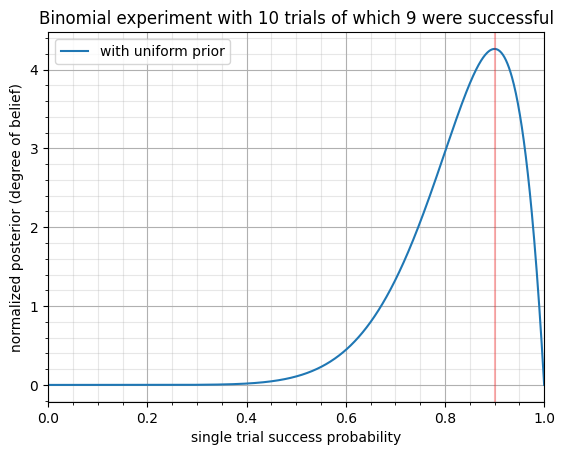

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import special
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def posterior_prob_binom_p(p, n_trials, n_successes, prior):
    return mp.mpf(p)**n_successes * mp.mpf(1-p)**(n_trials-n_successes) * prior(p)

posterior_prob_binom_p_vectorized = np.vectorize(posterior_prob_binom_p)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, bounds):
    mean = n_successes / n_trials
    std_dev = ( (n_successes-1)*(n_trials-n_successes+1) / (n_trials**2*(n_trials+1)) )**0.5
    prescale = 1/posterior_prob_binom_p(mean,n_trials, n_successes, prior)
    prior_prescaled = lambda p: prior(p) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_binom_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
        
    return norm / prescale

p = np.linspace(0, 1, 1001)

prior = lambda p: 1
norm = integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, [0, 1])
posterior_probs = posterior_prob_binom_p_vectorized(p, n_trials, n_successes, prior=prior) / norm
hypothesis_credibility = integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, [p_success_hypothesis, 1]) / norm
hypothesis_credibility_rounded = mp.nstr(hypothesis_credibility, round_to_digits)
print('You have conducted {} test of which {} were successful'.format(n_trials, n_successes))
print('The credibility of the hypothesis is {} that the success probability of a single trial is at least {}'.format(hypothesis_credibility_rounded, p_success_hypothesis))
plt.plot(p, posterior_probs, label='with uniform prior')
plt.axvline(p_success_hypothesis, 0, 1, color='red', alpha=0.3)

plt.gca().set_title('Binomial experiment with {} trials of which {} were successful'.format(n_trials, n_successes))
plt.gca().set_xlabel('single trial success probability'.format(n_trials))
plt.gca().set_ylabel('normalized posterior (degree of belief)')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.legend()

plt.gca().set_xlim([0, 1]); #change plot range here